# Titanic: Machine Learning From Disaster
### by Sung Ahn and Abdul Saleh

<hr>
## Introduction
In this project, we use a random forest classifier to predict who survived the sinking of the RMS Titanic. On our journey to achieving this goal, we go through the whole data science process from understanding the problem and getting the data to fine-tuning our models and visualizing our results. 

The Titanic dataset is perhaps the most widely analyzed dataset of all time. There are many incredible tutorials online exploring different approaches to analyzing this dataset. So in our own analysis, we draw on the experiences of many others who have already attempted this problem and shared their conclusions. We would especially like to thank [Manav Sehgal](https://www.kaggle.com/startupsci/titanic-data-science-solutions) and [Ahmed Besbes](https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html) whom without their insight this project would not have become a reality.    

<hr>
## Outline 
1. Understanding the problem
2. Getting the data
3. Exploring the data 
4. Picking a machine learning algorithm 
5. Preparing the data for machine learning algorithms
6. Training algorithm and fine-tuning model
7. Presenting solution and conclusion


<hr>
## Understanding the problem
Before we dive into the data analysis and algorithms, we first ask ourselves: is this even a problem that can be solved with machine learning? <br>
Luckily for us, lots of books have been written about the sinking of the Titanic. So before we look at the data, we do some background reading and discover that some patterns might exist, most notably: 

1. Women and children generally got first priority on the life boats 
    - This tells us that some people were more likely to survive than others
2. The third class living quarters were the furthest away from the deck with the lifeboats
    - This tells us that it was likely they got there after people had started crowding around the lifeboats
    - Considering that the time of impact was at 11:40 PM, most of the passengers were probably in their cabins at the time of impact
3. There was a lot of confusion during the sinking of the ship and people chose to stay on the Titanic for arbitrary reasons. 
    - There will definitely be anomalies in this dataset so we shouldn't expect our algorithm to have perfect accuracy.
4. The timeline of the sinking was as follows:
    - 2340: Impact at the starboard side
    - 0005: Orders given to uncover the lifeboats and get everyone ready
    - 0025: Lifeboat begin being loaded with women and children
    - 0045: First lifeboat lowered with less than half of its max capacity
    - 0205: The last lifeboat leaves the ship with over 1500 people left on the ship <br>
    
    - So it definitely took a while for the Titanic to sink and people to get on board the lifeboats
    
Aha, so it seems like a there are some patterns that can help us figure out who survived and who didn't. Our background reading also gave us tips about what we should look for. This looks like a great machine learning problem!

<hr>
## Getting the data
Kaggle, a platform for data science competitions, has kindly compiled a dataset that is perfect for our needs and put it on their [website](https://www.kaggle.com/c/titanic/data) for budding machine learning enthusiasts to use. The training dataset tells us who survived and who didn't so we can use it to train our model. The test set doesn't tell us the fate of the passengers - that's what we're supposed to predict!

After downloading the datasets, we import the data and a few libraries that we will use later on.  

In [1]:
# for data analysis and wrangling
import pandas as pd
import numpy as np
from fancyimpute import KNN
from math import ceil

# for visualizations
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# for machine learning
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# import data 
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

<hr>
## Exploring the data

Now let's take a look at the data:

In [5]:
display(train_data.head())
display(test_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### What do **Pclass**, **SibSp**, and **Parch** mean? <br>
According to Kaggle, **Pclass** = passenger class, **Sibsp** = # of siblings/spouses aboard the Titanic, **Parch** = # of parents/children aboard the Titanic. For more info about what the features mean visit [Kaggle.com](https://www.kaggle.com/c/titanic/data).
<br>

#### What are the feature types? 
We have a mix of numeric, alphanumeric, and categorical features here. We have to keep that in mind because we will be dealing with each type differently.
<br>
#### What's the size of the data?

In [7]:
# to find out size of data
print("training data dimensions:", train_data.shape)
print("test data dimensions:", test_data.shape)

training data dimensions: (891, 12)
test data dimensions: (418, 11)


#### What are the data types? Are there missing values?

In [8]:
train_data.info()
print('_'*125)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
_____________________________________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp     

#### Missing values:
- From training set:
    - 687 missing **Cabin** values
    - 177 missing **Age** values
    - 2 missing **Embarked** values
- From test set:
    - 327 missing **Cabin** values
    - 86 missing **Age** values

#### Check some quick summaries of the data to make sure nothing looks weird

In [13]:
# Summarize integer and float type features
display(train_data.describe())
display(test_data.describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [12]:
# Summarize object type features
display(train_data.describe(include=["O"]))
display(test_data.describe(include=["O"]))

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Davidson, Mr. Thornton",male,CA. 2343,G6,S
freq,1,577,7,4,644


,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Herman, Mr. Samuel",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


Everythin checks out. There are only 2 distinct **Sex** features so we don't need to correct misspelled entries or anything. The mean survival rate of the train data is ~38% which is around the actual ~32%.

<br>
Now let's visualize the data to learn more about the underlying patterns and the features that matter. Many of these graphs were copied from [Ahmed Besbes'](https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html) blog post about this dataset. We have made some minor adjustments here and offered interpretations relevant to our approach.

#### Passenger class and survival 

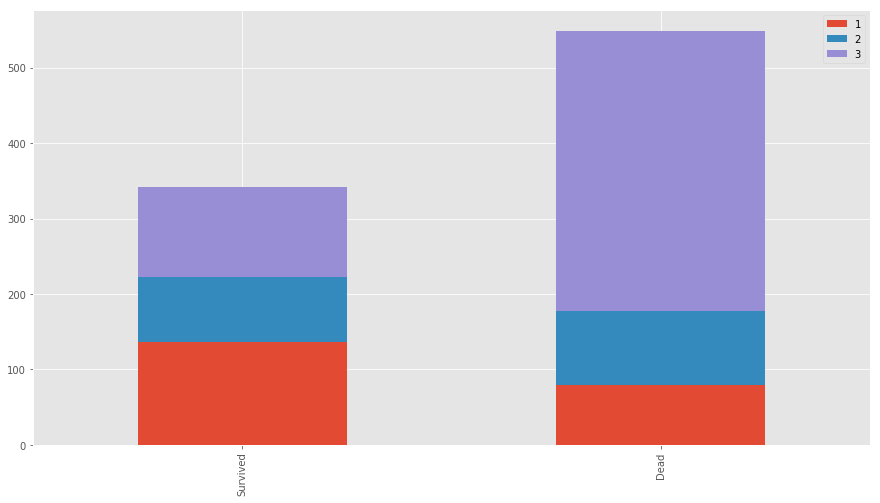

In [2]:
survived_class = train_data[train_data['Survived']==1]['Pclass'].value_counts()
dead_class = train_data[train_data['Survived']==0]['Pclass'].value_counts()
df = pd.DataFrame([survived_class,dead_class])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(15,8))

It looks like most 1st class passengers survived while most 2nd and 3rd class passengers didn't which tells us that class is going to be an important indicator of who is more likely to survive. 

#### Gender and survival

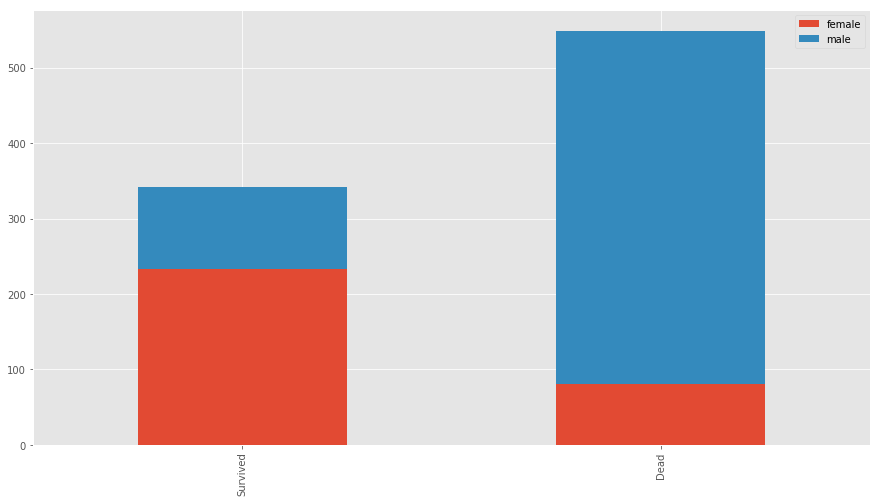

In [3]:
survived_sex = train_data[train_data['Survived']==1]['Sex'].value_counts()
dead_sex = train_data[train_data['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(15,8))

This confirms the research that we did earlier. It's clear that a much larger ratio of women survived compared to the ratio of men. 

#### Age and survival

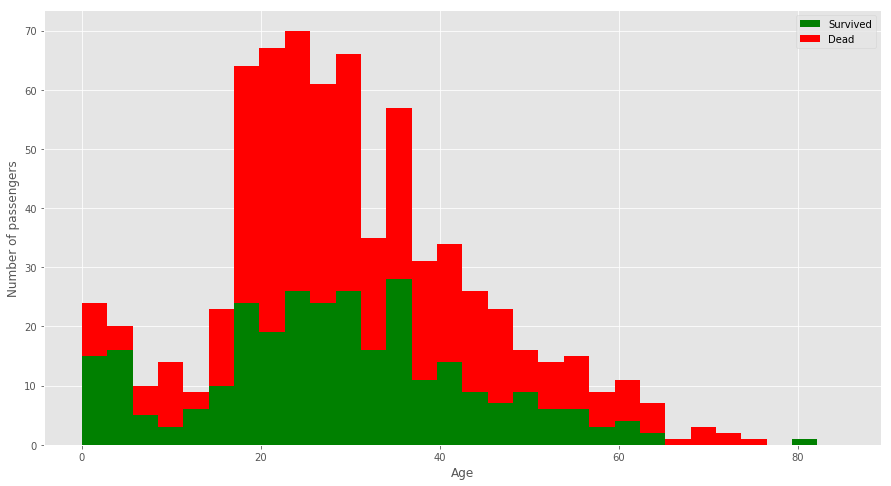

In [4]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Survived']==1]['Age'], train_data[train_data['Survived']==0]['Age']], 
         bins = 30, range = (0,85), align='mid', color = ['g','r'], label = ['Survived','Dead'], stacked=True)
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

It seems that very young kids were more likely to survive than adults. So age is a pretty important factor and it will be important to figure out a good way of filling in the missing ages. 

#### Fare and survival

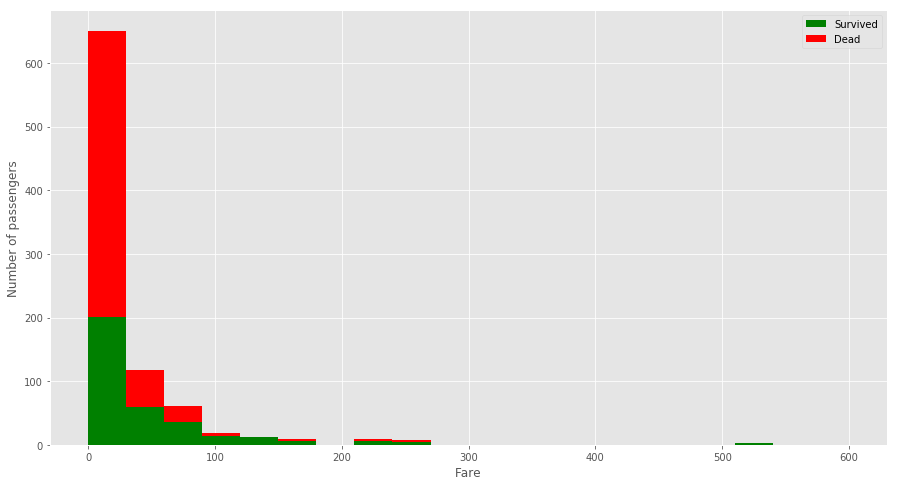

In [5]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Survived']==1]['Fare'], train_data[train_data['Survived']==0]['Fare']], 
         bins = 20, range = (0,600), color = ['g','r'], label = ['Survived','Dead'], stacked=True)
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

There might be a trend here but it's not really obvious. It seems like there is a higher percentage of survivors as the fare increases.  
<br>
We create another histogram only with fares above 30 to see if there really is a trend. 

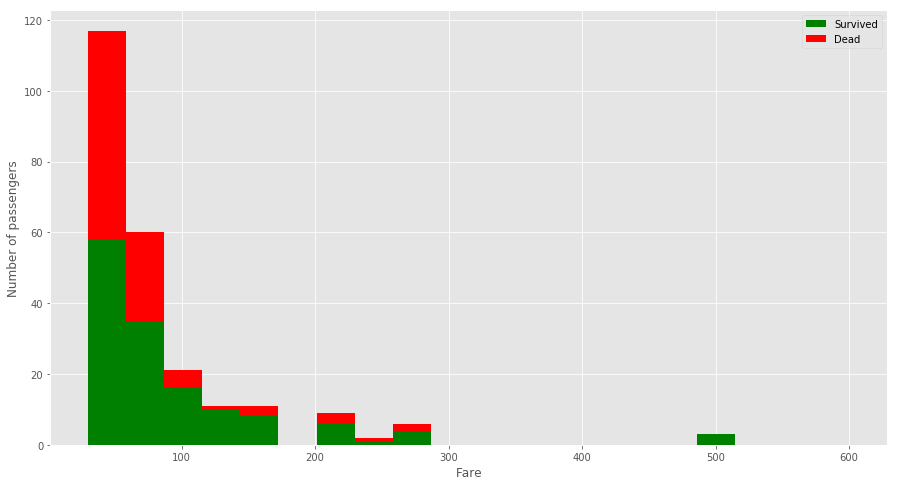

In [9]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Survived']==1]['Fare'], train_data[train_data['Survived']==0]['Fare']], 
         bins = 20, range = (30,600), color = ['g','r'], label = ['Survived','Dead'], stacked=True)
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

#### Embarked and survival

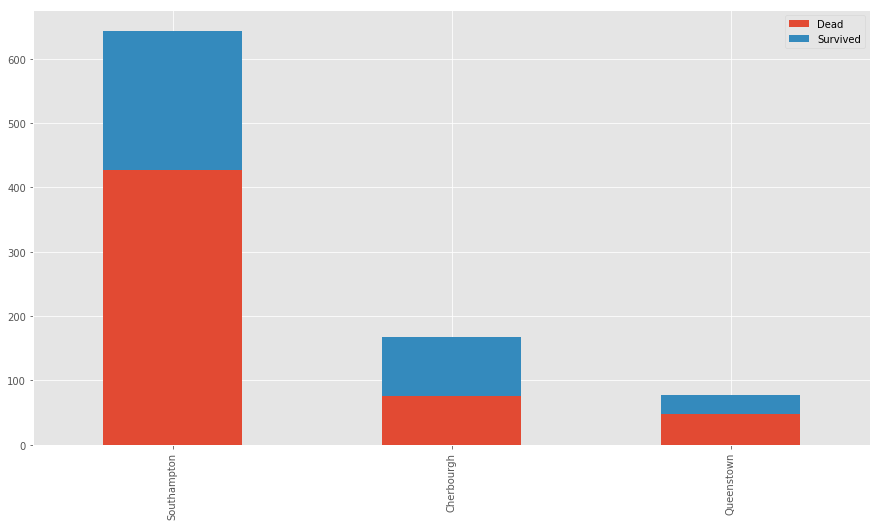

In [7]:
S = train_data[train_data['Embarked']=='S']['Survived'].value_counts()
C = train_data[train_data['Embarked']=='C']['Survived'].value_counts()
Q = train_data[train_data['Embarked']=='Q']['Survived'].value_counts()
df = pd.DataFrame([S,C,Q])
df.index = ['Southampton','Cherbourgh','Queenstown']
df.rename(index=str, columns={0: "Dead", 1: "Survived"}, inplace=True)
df.plot(kind='bar',stacked=True, figsize=(15,8))

It looks like there is a larger ratio of survival among people who embarked from Cherbourgh compared to people who embarked from Southampton and Queenstown.

#### Class and age

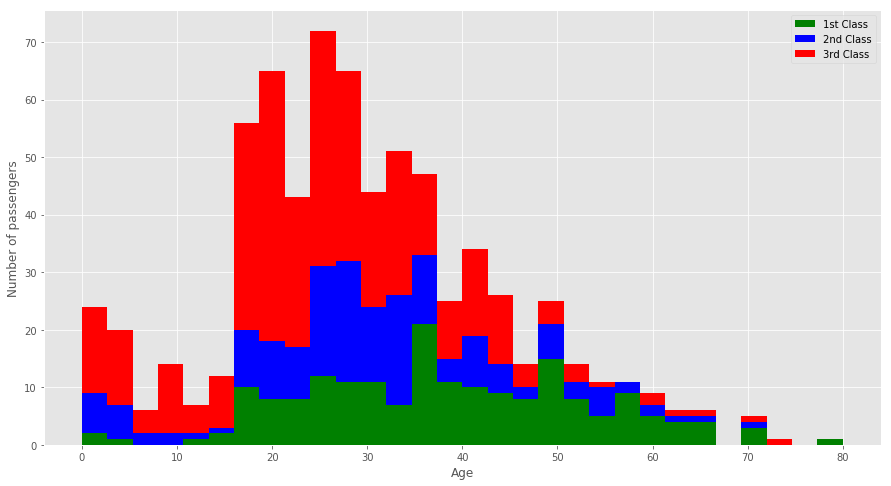

In [8]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Pclass']==1]['Age'], train_data[train_data['Pclass']==2]['Age'],train_data[train_data['Pclass']==3]['Age']], 
         bins = 30, range = (0,80), color = ['g','b','r'], label = ['1st Class','2nd Class','3rd Class'], stacked=True)
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

Older passengers tend to be in better classes. So when we're estimating the ages we will probably want to make an estimate that somehow incorporates the person's class. 

#### Age, fare, and survival

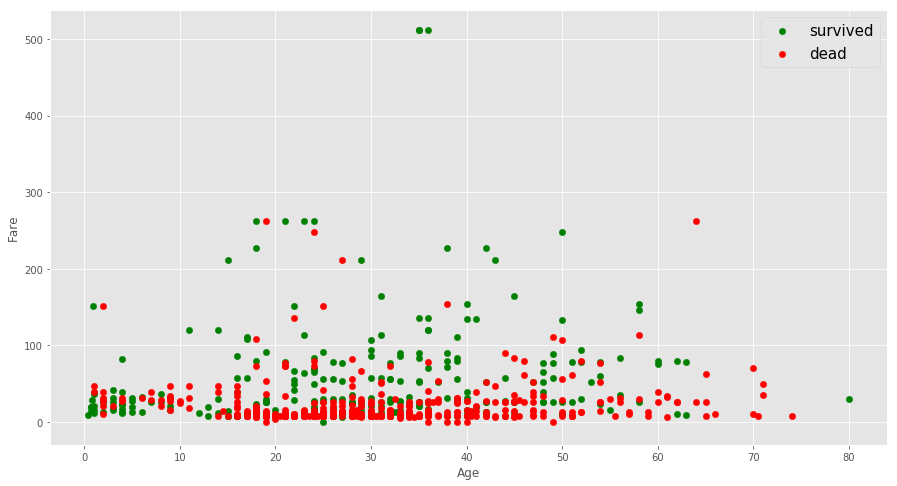

In [10]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.scatter(train_data[train_data['Survived']==1]['Age'],train_data[train_data['Survived']==1]['Fare'],c='green',s=40)
ax.scatter(train_data[train_data['Survived']==0]['Age'],train_data[train_data['Survived']==0]['Fare'],c='red',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.legend(('survived','dead'),scatterpoints=1,loc='upper right',fontsize=15,)

This graph provides a good summary of the many relationships we observed earilier. Notice that there is a high concentration of green dots on the left, towards younger ages. And also notice that there is a higher concentration of green dots as the far increases.

<hr>
## Picking an algorithm

We are going to use a random forest classifier to predict who survived and who didn't. A random forest are basically just a collection of decision trees. Decision trees ask a hierarchy of if/else questions until a decision is reached. Decision trees usually tend to overfit, meaning that they are very good at predicting things about the training data, but they fail to generalize to unseen data. Random forests address this problem by introducing some randomness into the problem. Each decision tree in a random forest is slightly different from the other, and each tree overfits in different ways because of the randomness associated with creating the trees. Then the outputs of all these individual trees are averaged to produce a result that is better than each tree's individual output and is less prone to overfitting. 
<br><br>
Here we are going to use the H2O implementation of the random forest classifier instead of the more commonly used scikit-learn implementation because it has been [shown](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/) that the way scikit-learn random forests deal with categorical variables introduces bias. In addition, there are no tutorials online analyzing the Titanic dataset using H2O and we wanted to contribute something new to the community of people who have attempted this problem. 

<hr>
## Preparing the data for machine learning algorithms
First we start by combining the training dataset and the test dataset so that we can edit them both together and ensure they end up in the same format. 


In [11]:
# Store the survival data
targets = train_data.Survived

# Drop survival data so training set and test set have the same shape and can be combined
train_data_dropped = train_data.drop(["Survived"], 1)

# Combine train and test data
combined_data = train_data_dropped.append(test_data)

combined_data.shape

(1309, 11)

The training data had 891 entries and the test data had 418 entries. $418 + 891 = 1309$ entires, so this looks good!

### Extracting passenger titles: 

If you look back at the data you will notice that passenger titles are always preceded by a comma and followed by a period. So we can create a function that splits the Name value at the comma and at the period to get the title.

In [12]:
# Extract titles from names and place them in a new column
combined_data["Title"] = combined_data["Name"].map(lambda name: name.split(",")[1].split(".")[0].strip())

# Show all different values in the Title column
combined_data.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Mlle              2
Major             2
Sir               1
Don               1
Mme               1
Lady              1
Capt              1
Dona              1
Jonkheer          1
the Countess      1
Name: Title, dtype: int64

Looks like it worked!
<br>
We can also group similar titles together to simplify our model and reduce the risk of overfitting. We don't really want our model to be too complex. For example, it would be nice if our model knows how to predict outcomes for countesses, but chances are, there aren't that many countesses on the Titanic, so it would be better to group Royalties  together so that our model generalizes better when looking at new data.   

In [13]:
Title_dict = {
    "Mr":"Mr",
    "Miss":"Ms",
    "Mrs":"Mrs",
    "Master":"Master",
    "Dr":"Other",
    "Rev":"Other",
    "Col":"Military",
    "Ms":"Ms",
    "Mlle":"Ms",
    "Major":"Military",
    "Don":"Royal or Noble",
    "the Countess":"Royal or Noble",
    "Lady":"Royal or Noble",
    "Dona":"Royal or Noble",
    "Sir":"Royal or Noble",
    "Mme":"Mrs",
    "Jonkheer":"Royal or Noble",
    "Capt":"Other"
}

# Group titles using mappings in dictionary above
combined_data["Title"] = combined_data["Title"].map(Title_dict) 

combined_data["Title"].value_counts()

Mr                757
Ms                264
Mrs               198
Master             61
Other              17
Royal or Noble      6
Military            6
Name: Title, dtype: int64

### Processing passenger ages:

If you recall from the data exploration step, there were about 177 and 86 missing age values from the training set and the data set respectively. We know that age is an important factor in determining survival so we need to come up with a way to fill in the missing ages.

Here we are going to group people by their gender, class, and title.

In [14]:
# Select train data and group by Sex, class, and title in that order
grouped_train_data = combined_data.head(891).groupby(["Sex","Pclass", "Title"])

# Select test data and group by Sex, class, and title in that order
grouped_test_data = combined_data.iloc[891:].groupby(["Sex", "Pclass", "Title"])

# Find and display medians 
display(grouped_train_data.median())
print('_'*125)
display(grouped_test_data.median())

PassengerId   Age  SibSp  Parch       Fare
Sex    Pclass Title                                                     
female 1      Mrs                   499.0  40.0    1.0    0.0   79.20000
              Ms                    369.0  30.0    0.0    0.0   88.25000
              Other                 797.0  49.0    0.0    0.0   25.92920
              Royal or Noble        658.5  40.5    0.5    0.0   63.05000
       2      Mrs                   438.0  32.0    1.0    0.0   26.00000
              Ms                    444.0  24.0    0.0    0.0   13.00000
       3      Mrs                   405.5  31.0    1.0    1.0   15.97500
              Ms                    372.0  18.0    0.0    0.0    8.75625
male   1      Master                446.0   4.0    1.0    2.0  120.00000
              Military              592.5  54.0    0.0    0.0   28.52500
              Mr                    463.0  40.0    0.0    0.0   42.40000
              Other                 661.0  47.0    1.0    0.0   71.00000
              Royal or Noble        600.0  40.0    0.0    0.0   27.72080
       2      Master                408.0   1.0    1.0    1.0   26.00000
              Mr                    440.0  31.0    0.0    0.0   13.00000
              Other                 358.5  46.5    0.0    0.0   13.00000
       3      Master                270.5   4.0    3.5    1.0   28.51250
              Mr                    472.0  26.0    0.0    0.0    7.89580

_____________________________________________________________________________________________________________________________


PassengerId   Age  SibSp  Parch       Fare
Sex    Pclass Title                                                     
female 1      Mrs                  1076.0  48.0    1.0    0.0   63.35830
              Ms                   1074.0  32.0    0.0    0.0  158.20835
              Royal or Noble       1306.0  39.0    0.0    0.0  108.90000
       2      Mrs                  1123.5  29.0    0.0    0.0   26.00000
              Ms                   1121.0  19.5    1.0    1.0   24.50000
       3      Mrs                  1051.0  28.0    1.0    1.0   14.45420
              Ms                   1089.0  22.0    0.0    0.0    7.87920
male   1      Master               1022.0   9.5    1.0    2.0  198.43750
              Military             1058.5  50.0    0.5    0.0  128.01250
              Mr                   1102.0  42.0    0.0    0.0   50.24790
              Other                1185.0  53.0    1.0    1.0   81.85830
       2      Master               1033.5   5.0    0.5    1.5   27.75000
              Mr                   1156.0  28.0    0.0    0.0   13.00000
              Other                1048.5  35.5    0.5    0.5   19.50000
       3      Master               1173.0   7.0    1.0    1.0   15.24580
              Mr                   1101.0  25.0    0.0    0.0    7.85420

Here we can see that a person's class and title change substantially with their age. So the function we will create to fill in the missing ages first checks the passenger's age, then their class, then their title and uses that info to determine what age to give them.

 <div class="alert alert-block alert-warning">Note that we have to be super careful not to introduce any information from the test data into the training data. The point of a predictive machine learning model is to make accurate predictions about new data that is *unseen* during the training.</div>

In [ ]:
# Function to round approximations of missing ages to nearest 0.5             
def round_age(age):
    return round(age * 2) / 2


# Function that fills in missing ages
def age_filler(incomplete_data, grouped_data, Training=True, size=0):
    # Ensure every passenger has a unique index
    if Training != True:
        incomplete_data = incomplete_data.reset_index()   
    
    # iterate over each three item tuple of sex, class, and title in the grouped data
    for row in grouped_data:
        try:
            # This is a data frame the has the age and fares of passengers sharing the same gender, class, and title
            subset_incomplete_data = incomplete_data.loc[(incomplete_data["Sex"]==row[0][0]) 
                                                        & (incomplete_data["Pclass"]==row[0][1]) 
                                                        & (incomplete_data["Title"]==row[0][2]), 
                                                        (["Age", "Fare"])]
        # Skip to next row if no values are found
        except KeyError:
            continue
            
        # Array of global indexes of passengers in subset with missing ages
        missing_ages_global_index = subset_incomplete_data.index[subset_incomplete_data["Age"].isnull()].tolist()
        missing_ages_global_index.sort()

        # Array of local indexes of passengers in subset with missing ages
        missing_ages_local_index = np.where(subset_incomplete_data["Age"].isnull())[0]
        missing_ages_local_index.sort()

        # Get number of passengers in subset_train_data, will use this number to calculate number of KNN neighbours 
        subset_incomplete_data_size = subset_incomplete_data.shape[0]
        
        try:
            # Use KNN to fill in missing ages based on similarities between passegers' fares
            # Returns an unindexed but ordered numpy array of ages
            subset_complete_data = KNN(k=ceil(subset_incomplete_data_size*0.05)).complete(subset_incomplete_data)
        # Handles case when there are no missing values
        except ValueError:
            continue
            
        counter = 0
        # Iterate over estimated ages in subset and place them back in the original dataset
        # Use indexes to match values from subset to original data set
        for passenger_local_index in missing_ages_local_index:
            passenger_estimated_age = round_age(subset_complete_data[passenger_local_index][0])
            passenger_global_index = missing_ages_global_index[counter]
            counter+=1
            completed_data = incomplete_data.set_value(passenger_global_index, "Age", passenger_estimated_age)
    # Handles test set
    if Training != True:
        return completed_data.iloc[size:] 
    # Handles training set
    else:
        return completed_data

train_data = combined_data.head(891)

# Estimate missing ages in training set, pass in a copy so that original data set is not changed
train_data_filled = age_filler(train_data.copy(), grouped_train_data)

# Estimate missing ages in test set
test_data_filled = age_filler(combined_data.copy(), grouped_train_data, Training = False, size = 891)

# Combining training and test set after filling in all ages
combined_data = train_data_filled.append(test_data_filled).reset_index()

Let's go through what this function does: 
- This function takes in a pandas dataframe with missing ages and returns a pandas dataframe with no missing ages
- For each (sex, class, title) tuple in the grouped data table, this function isolates passengers with the same sex, class, and title and stores this subset in `subset_incomplete_data`. 
- Then the global indexes of the passengers with missing ages are stored in `missing_ages_global_index`.
- Then the local indexes (relative position in the subset) of passengers with missing ages are stores in `missing_ages_local_index`.
- Then the missing ages are estimated using the k-nearest neighbours method which assigns passengers with similar fares similar ages within each subset. We get the result in the form of an ordered numpy array so we have to move the estimates ages from the array back into out dataset.
- Then the `missing_ages_local_index` is used to locate the estimated ages in the numpy array and the corresponding value in the `missing_ages_global_index` is used to determine were to put the estimate ages back in the main dataset.
- The `Training` boolean variable is used to ensure that the test set does not affect the training set, but the training set is still allowed to affect the test set.

In [9]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
level_0        1309 non-null int64
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Ticket         1309 non-null object
Title          1309 non-null object
index          418 non-null float64
dtypes: float64(3), int64(5), object(6)
memory usage: 143.2+ KB


No more missing ages!

### Processing Fare and Embarked features

In this data set we have one missing Fare value and two missing Embarked values, so let's just fill them in directly. The approach we take here is very similar to the approach we took above but now we use modes and medians instead of k-nearest neighbours.
<br><br>
First: let's look at the passenger with a missing fare

In [16]:
missing_fare_index = combined_data.index[combined_data["Fare"].isnull()]
combined_data.iloc[missing_fare_index]

,level_0,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Title,index
1043,1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,3701,Mr,152.0


This passenger is a male in 3rd class whose title is Mr.
Let's find the subset of passengers who also have the same gender, class, and title as this passenger and then assign him the median fare of that subset.

In [17]:
subset = combined_data.loc[(combined_data["Sex"]=="male")
                          & (combined_data["Pclass"]==3)
                          & (combined_data["Title"]=="Mr")]

# Fill empty fare with median
combined_data["Fare"].fillna(float(subset["Fare"].median()), inplace=True)

In [18]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
level_0        1309 non-null int64
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Ticket         1309 non-null object
Title          1309 non-null object
index          418 non-null float64
dtypes: float64(3), int64(5), object(6)
memory usage: 143.2+ KB


No more missing fares! 
<br>

Now we do a similar thing for the missing Embarked values, but we replace missing values with the mode instead.
We also make sure we do not leak data from the test set to the training set.

In [13]:
missing_embarked_index = combined_data.index[combined_data["Embarked"].isnull()]
missing_embarked_rows = combined_data.iloc[missing_embarked_index]
display(missing_embarked_rows)

,level_0,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Title,index
61,61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,113572,Ms,NaN
829,829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,113572,Mrs,NaN


In [14]:
for index, row in missing_embarked_rows.iterrows():
    subset = combined_data.head(891).loc[(combined_data.head(891)["Sex"]==row["Sex"])
                                        & (combined_data.head(891)["Pclass"]==row["Pclass"])
                                        & (combined_data.head(891)["Title"]==row["Title"])]                                    
    # Fill empty fields with mode
    combined_data.set_value(index, "Embarked", str(subset["Embarked"].mode().iloc[0])) 

In [15]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
level_0        1309 non-null int64
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Ticket         1309 non-null object
Title          1309 non-null object
index          418 non-null float64
dtypes: float64(3), int64(5), object(6)
memory usage: 143.2+ KB


Fare and Emarked now have no missing values.

### Creating Family_Size

Now we are going to create the **Family_Size** feature by adding **SibSp** and **Parch** and 1. This is makes sense because a **Family_Size** feature might be a better predictor than either of the other features separatley. Families tend to stick together, which probably affected their chanced of survival. We then drop the **SibSp** and **Parch** columns because the information the contain are summarized by the new **Family_Size** feature.
<br><br>
We also drop the **Cabin** feature because there are so many missing value it might not be worthwhile trying to fill them and also because the cabin numbers might not contain new info. We know the cabin data because an incomplete first class passenger list was recovered with the body of steward Herbert Cave so **Pclass** probably already encodes the cabin info.
<br><br>
We also drop ticket numbers because it is not clear why ticket number would correlate with survival. However, it is definitley something worth exploring more. We just won't do that here.

In [20]:
combined_data["Family_Size"] = combined_data["SibSp"] + combined_data["Parch"] + 1

# Drop all columns we don't need
combined_data_dropped = combined_data.drop(["Name", "SibSp", "Parch", "Cabin", "Ticket", "PassengerId", "index","level_0"], 1)

train_data_final = combined_data_dropped.head(891).copy().reset_index().drop(["index"],1)
display(train_data_final.head())
test_data_final = combined_data_dropped.iloc[891:].copy()
display(test_data_final.head())

,Age,Embarked,Fare,Pclass,Sex,Title,Family_Size
0,22.0,S,7.2500,3,male,Mr,2
1,38.0,C,71.2833,1,female,Mrs,2
2,26.0,S,7.9250,3,female,Ms,1
3,35.0,S,53.1000,1,female,Mrs,2
4,35.0,S,8.0500,3,male,Mr,1


,Age,Embarked,Fare,Pclass,Sex,Title,Family_Size
891,34.5,Q,7.8292,3,male,Mr,1
892,47.0,S,7.0000,3,female,Mrs,2
893,62.0,Q,9.6875,2,male,Mr,1
894,27.0,S,8.6625,3,male,Mr,1
895,22.0,S,12.2875,3,female,Mrs,3


## Training algorithm and fine-tuning model

Create an H2O instance:

In [ ]:
h2o.init()

We append the survival data back to the training set. And we convert the data we are working with into H2O dataframes so that the H2O algorithms can work with them. We also

In [11]:
train_data_final_surv = train_data_final.join(targets)
train_data_final_surv.head()

# Convert to H2O dataframes
h2o_train_data = h2o.H2OFrame(train_data_final_surv)
h2o_test_data = h2o.H2OFrame(test_data_final)

display(h2o_train_data)
display(h2o_test_data)

Age,Embarked,Fare,Pclass,Sex,Title,Family_Size,Survived
22,S,7.25,3,male,Mr,2,0
38,C,71.2833,1,female,Mrs,2,1
26,S,7.925,3,female,Ms,1,1
35,S,53.1,1,female,Mrs,2,1
35,S,8.05,3,male,Mr,1,0
25,Q,8.4583,3,male,Mr,1,0
54,S,51.8625,1,male,Mr,1,0
2,S,21.075,3,male,Master,5,0
27,S,11.1333,3,female,Mrs,3,1
14,C,30.0708,2,female,Mrs,2,1


Age,Embarked,Fare,Pclass,Sex,Title,Family_Size
34.5,Q,7.8292,3,male,Mr,1
47,S,7,3,female,Mrs,2
62,Q,9.6875,2,male,Mr,1
27,S,8.6625,3,male,Mr,1
22,S,12.2875,3,female,Mrs,3
14,S,9.225,3,male,Mr,1
30,Q,7.6292,3,female,Ms,1
26,S,29,2,male,Mr,3
18,C,7.2292,3,female,Mrs,1
21,S,24.15,3,male,Mr,3


Now we have to make sure that Pclass and Survival are treated as categorical variables not numerical ones.

In [37]:
h2o_train_data["Survived"] = h2o_train_data["Survived"].asfactor() 
h2o_train_data["Pclass"] = h2o_train_data["Pclass"].asfactor()
h2o_train_data.types

{'Age': 'real',
 'Embarked': 'enum',
 'Family_Size': 'int',
 'Fare': 'real',
 'Pclass': 'enum',
 'Sex': 'enum',
 'Survived': 'enum',
 'Title': 'enum'}

Then we create a random forest instance with default parameters. The nfolds refers to 10-fold cross validation, which is a validation method that separates the data into 10 subsets. 9 subsets are used for training and the last subset is used for validation to test the accuracy of out model. This is repeated for each subset and the model accuracy is determined by averaging the results of the 10 trials. 

In [26]:
RF_default = H2ORandomForestEstimator(nfolds=10)                       

Now let's train our model:

In [39]:
# Get names of columns that contain the features we want to train the algorithm on
feature_names = h2o_train_data.col_names[0:-1]
# Get name of column that has targets
targets_name = h2o_train_data.col_names[-1]

# We train our model
RF_default.train(feature_names, targets_name, training_frame=h2o_train_data)

In [28]:
# Display how model performed on train data
RF_default.model_performance()


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.13068263237979708
RMSE: 0.3615005288790005
LogLoss: 0.4695158848080966
Mean Per-Class Error: 0.18507333908541845
AUC: 0.871438234322905
Gini: 0.74287646864581
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4436601003011068: 


,0,1,Error,Rate
0,471.0,78.0,0.1421,(78.0/549.0)
1,78.0,264.0,0.2281,(78.0/342.0)
Total,549.0,342.0,0.1751,(156.0/891.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4436601,0.7719298,183.0
max f2,0.1269003,0.8061172,302.0
max f0point5,0.7014454,0.8255086,108.0
max accuracy,0.6504395,0.8316498,124.0
max precision,1.0,0.9814815,0.0
max recall,0.0043346,1.0,397.0
max specificity,1.0,0.9981785,0.0
max absolute_mcc,0.6504395,0.6409628,124.0
max min_per_class_accuracy,0.3614987,0.7941712,209.0
max mean_per_class_accuracy,0.4436601,0.8149267,183.0


Gains/Lift Table: Avg response rate: 38.38 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0606061,1.0,2.5570175,2.5570175,0.9814815,0.9814815,0.1549708,0.1549708,155.7017544,155.7017544
,2,0.1032548,0.96875,2.3310249,2.4636728,0.8947368,0.9456522,0.0994152,0.2543860,133.1024931,146.3672769
,3,0.1503928,0.9048802,2.3571429,2.4302828,0.9047619,0.9328358,0.1111111,0.3654971,135.7142857,143.0282797
,4,0.2008979,0.8319722,2.3736842,2.4160541,0.9111111,0.9273743,0.1198830,0.4853801,137.3684211,141.6054102
,5,0.3007856,0.6225130,1.8149024,2.2164179,0.6966292,0.8507463,0.1812865,0.6666667,81.4902425,121.6417910
,6,0.4006734,0.4141926,1.0830869,1.9338788,0.4157303,0.7422969,0.1081871,0.7748538,8.3086931,93.3878815
,7,0.5005612,0.2366864,0.7318155,1.6940052,0.2808989,0.6502242,0.0730994,0.8479532,-26.8184506,69.4005192
,8,0.6004489,0.140625,0.3512714,1.4706345,0.1348315,0.5644860,0.0350877,0.8830409,-64.8728563,47.0634530
,9,0.7003367,0.0916039,0.4098167,1.3193320,0.1573034,0.5064103,0.0409357,0.9239766,-59.0183323,31.9331984
,10,0.8002245,0.0575447,0.3219988,1.1948402,0.1235955,0.4586255,0.0321637,0.9561404,-67.8001183,19.4840186


The two things we care about in the output above are the "AUC" and the missclassification rate. AUC is one metric to measure the accuracy of binomial classification problems. A higher AUC is better. And the missclassification rate is the ratio of predictions the model got wrong. When the model was tested on the training data the AUC was 0.8714 and the missclassification rate was 149/891. So 149 predictions were incorrect.

### Parameter tuning

There are tens of parameters we can adjust here. We can choose the number of trees, the depth of each tree, the number of variables to decide each split, and so on. There is a very useful class called GridSearch that trains different models with different parameters and shows us how accurate each model is so we can pick the optimal parameters. <br>

First we create another random forest with 400 trees and `binomial_double_trees` set to True. These two parameters increases the number of trees and therefore the training time, but the final predictions are more accurate. 

In [30]:
RF_1 = H2ORandomForestEstimator(ntrees=400,
                                nfolds=10,
                                binomial_double_trees=True
                               )

In [31]:
#Then we choose the parameters we want to try
hyper_params_1={"max_depth": [20, 40, 60],
                "min_rows": [2, 3, 4],
                "mtries": [2, 3, 4]
               }

# Then we create a grid_search instance
grid_search_1 = h2o.grid.H2OGridSearch(RF_1, hyper_params_1)

# And we carry out the search
grid_search_1.train(feature_names, targets_name, training_frame=h2o_train_data)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [38]:
grid_search_1_results = grid_search_1.get_grid(sort_by="auc", decreasing = True)
results_1 = grid_search_1_results.sorted_metric_table()
results_1

,,max_depth,min_rows,mtries,model_ids,auc
0,,40,2.0,2,Grid_DRF_py_2_sid_a1fb_model_python_1512592688436_10797_model_1,0.8830089796440099
1,,60,3.0,2,Grid_DRF_py_2_sid_a1fb_model_python_1512592688436_10797_model_5,0.8819171486700966
2,,60,2.0,2,Grid_DRF_py_2_sid_a1fb_model_python_1512592688436_10797_model_2,0.8817147604895664
3,,40,4.0,2,Grid_DRF_py_2_sid_a1fb_model_python_1512592688436_10797_model_7,0.8812886801095027
4,,20,4.0,3,Grid_DRF_py_2_sid_a1fb_model_python_1512592688436_10797_model_15,0.880154241097583
5,,40,3.0,3,Grid_DRF_py_2_sid_a1fb_model_python_1512592688436_10797_model_13,0.8800557100096934
6,,60,4.0,3,Grid_DRF_py_2_sid_a1fb_model_python_1512592688436_10797_model_17,0.8799784829408068
7,,40,4.0,4,Grid_DRF_py_2_sid_a1fb_model_python_1512592688436_10797_model_25,0.8797627797483994
8,,40,2.0,4,Grid_DRF_py_2_sid_a1fb_model_python_1512592688436_10797_model_19,0.879437893458601
9,,20,4.0,2,Grid_DRF_py_2_sid_a1fb_model_python_1512592688436_10797_model_6,0.8787055678053665


Here `max_depth` refers to how deep each tree is allowed to grow. `min_rows` refers to the minimum number of observations required to create a new path in the tree. `mtries` refers to how many variables to randomly choose as candidates at each split.
<br>
We can see above that `mtries`=2  seems to create the best models. However, it is not clear what the best values for `max_depth` and `min_rows` are so we carry out another grid search to see if there is any obvious winner. We also want to check whether `mtries`=1 is better than `mtries`=2.

In [14]:
# We create another random forest for the sake of uniformity but this is not required
RF_2 = H2ORandomForestEstimator(ntrees=400,
                                nfolds=10,
                                binomial_double_trees=True
                               )


#We choose the other parameters we want to try
hyper_params_2={"max_depth": [10, 20, 40, 60],
                "min_rows": [1, 2, 3, 4],
                "mtries": [1, 2]
               }

# Then we create a grid_search instance
grid_search_2 = h2o.grid.H2OGridSearch(RF_2, hyper_params_2)

# And we carry out the search
grid_search_2.train(feature_names, targets_name, training_frame=h2o_train_data)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [15]:
grid_search_2_results = grid_search_2.get_grid(sort_by="auc", decreasing = True)
results_2 = grid_search_2_results.sorted_metric_table()
results_2

,,max_depth,min_rows,mtries,model_ids,auc
0,,40,2.0,2,Grid_DRF_py_2_sid_8ae9_model_python_1512600678966_1_model_22,0.8821594818862578
1,,60,2.0,2,Grid_DRF_py_2_sid_8ae9_model_python_1512600678966_1_model_23,0.8819650827128538
2,,20,3.0,2,Grid_DRF_py_2_sid_8ae9_model_python_1512600678966_1_model_25,0.8802261421617189
3,,10,4.0,2,Grid_DRF_py_2_sid_8ae9_model_python_1512600678966_1_model_28,0.8784712235963315
4,,20,4.0,2,Grid_DRF_py_2_sid_8ae9_model_python_1512600678966_1_model_29,0.8779279711117502
5,,40,3.0,2,Grid_DRF_py_2_sid_8ae9_model_python_1512600678966_1_model_26,0.8778161250119836
6,,60,4.0,2,Grid_DRF_py_2_sid_8ae9_model_python_1512600678966_1_model_31,0.8773500995962888
7,,20,2.0,2,Grid_DRF_py_2_sid_8ae9_model_python_1512600678966_1_model_21,0.8773208065701594
8,,20,1.0,2,Grid_DRF_py_2_sid_8ae9_model_python_1512600678966_1_model_17,0.8770332023136165
9,,10,1.0,2,Grid_DRF_py_2_sid_8ae9_model_python_1512600678966_1_model_16,0.8765511988836694


Now it is quite clear that `mtries`=2 is the best choice, so let's stick with `mtries`=2. <br>
`min_rows`=2 and `max_depth`=40 and `max_depth`=60 came out on top again so it seems like this combination might be optimal.<br><br>
Let's do another grid search to try and figure out whether `max_depth` and `min_rows` really matter. 

In [21]:
# We create another random forest with the parameters we chose to stick with
RF_3 = H2ORandomForestEstimator(ntrees=400,
                                nfolds=10,
                                binomial_double_trees=True,
                                mtries=2
                               )


#We choose the other parameters we want to try
hyper_params_3={"max_depth": [5, 10, 40, 50, 60, 70],
                "min_rows": [2, 3, 4, 5]
               }

# Then we create a grid_search instance
grid_search_3 = h2o.grid.H2OGridSearch(RF_3, hyper_params_3)

# And we carry out the search
grid_search_3.train(feature_names, targets_name, training_frame=h2o_train_data)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [23]:
grid_search_3_results = grid_search_3.get_grid(sort_by="auc", decreasing = True)
results_3 = grid_search_3_results.sorted_metric_table()
results_3

,,max_depth,min_rows,model_ids,auc
0,,50,2.0,Grid_DRF_py_5_sid_96fb_model_python_1512605674139_1_model_3,0.8819144856677212
1,,50,4.0,Grid_DRF_py_5_sid_96fb_model_python_1512605674139_1_model_15,0.8810942809360987
2,,50,5.0,Grid_DRF_py_5_sid_96fb_model_python_1512605674139_1_model_21,0.8799412009075511
3,,60,3.0,Grid_DRF_py_5_sid_96fb_model_python_1512605674139_1_model_10,0.8798852778576679
4,,70,4.0,Grid_DRF_py_5_sid_96fb_model_python_1512605674139_1_model_17,0.8796882156818884
5,,60,2.0,Grid_DRF_py_5_sid_96fb_model_python_1512605674139_1_model_4,0.8796029996058756
6,,40,4.0,Grid_DRF_py_5_sid_96fb_model_python_1512605674139_1_model_14,0.8786363297436062
7,,70,2.0,Grid_DRF_py_5_sid_96fb_model_python_1512605674139_1_model_5,0.8786176887269783
8,,40,3.0,Grid_DRF_py_5_sid_96fb_model_python_1512605674139_1_model_8,0.8785324726509656
9,,60,4.0,Grid_DRF_py_5_sid_96fb_model_python_1512605674139_1_model_16,0.877358088603415


There isn't a huge difference between the trails but `max_depth`=50 seems to occupy the top 3 positions. So let's stick with `max_depth`=50. `min_rows` looks quite arbitrary so we will just stick with the default values. 
<br><br>
Now we will also gridsearch over the parameters `col_sample_rate_per_tree` which is like `mtries` but at the tree level and `sample_rate` which determines the percentage of the data each tree is trained on. 

In [31]:
# We create another random forest with the parameters we chose to stick with
RF_4 = H2ORandomForestEstimator(ntrees=400,
                                nfolds=10,
                                binomial_double_trees=True,
                                mtries=2,
                                max_depth=50
                               )


#We choose the other parameters we want to try
hyper_params_4={"sample_rate": [0.5, 0.6, 0.7, 0.8],
                "col_sample_rate_per_tree": [0.4, 0.6, 0.8, 0.9, 1]
               }

# Then we create a grid_search instance
grid_search_4 = h2o.grid.H2OGridSearch(RF_4, hyper_params_4)

# And we carry out the search
grid_search_4.train(feature_names, targets_name, training_frame=h2o_train_data)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [33]:
grid_search_4_results = grid_search_4.get_grid(sort_by="auc", decreasing = True)
results_4 = grid_search_4_results.sorted_metric_table()
results_4

,,col_sample_rate_per_tree,sample_rate,model_ids,auc
0,,0.4,0.7,Grid_DRF_py_9_sid_a72b_model_python_1512608239217_1_model_10,0.8865001757581568
1,,0.6,0.6,Grid_DRF_py_9_sid_a72b_model_python_1512608239217_1_model_6,0.8858583921856859
2,,0.6,0.7,Grid_DRF_py_9_sid_a72b_model_python_1512608239217_1_model_11,0.8849716123946783
3,,0.4,0.8,Grid_DRF_py_9_sid_a72b_model_python_1512608239217_1_model_15,0.8837652723186229
4,,0.4,0.5,Grid_DRF_py_9_sid_a72b_model_python_1512608239217_1_model_0,0.8805776584752714
5,,0.8,0.5,Grid_DRF_py_9_sid_a72b_model_python_1512608239217_1_model_2,0.879605662608251
6,,0.6,0.5,Grid_DRF_py_9_sid_a72b_model_python_1512608239217_1_model_1,0.8794671864847303
7,,0.8,0.7,Grid_DRF_py_9_sid_a72b_model_python_1512608239217_1_model_12,0.8787295348267451
8,,0.6,0.8,Grid_DRF_py_9_sid_a72b_model_python_1512608239217_1_model_16,0.8785537766699687
9,,0.9,0.8,Grid_DRF_py_9_sid_a72b_model_python_1512608239217_1_model_18,0.8785164946367132


It doesn't look like the `sample_rate` is making a difference so we will stick with the defaults. But for the `col_sample_rate_per_tree` 0.4 and 0.6 are towards the top so lets do a final grid search over the `col_sample_rate_per_tree`.

In [40]:
# We create another random forest with the parameters we chose to stick with
RF_5 = H2ORandomForestEstimator(ntrees=400,
                                nfolds=10,
                                binomial_double_trees=True,
                                mtries=2,
                                max_depth=50
                               )


#We choose the other parameters we want to try
hyper_params_5={"col_sample_rate_per_tree": [0.2, 0.3, 0.4, 0.5, 0.6]}

# Then we create a grid_search instance
grid_search_5 = h2o.grid.H2OGridSearch(RF_5, hyper_params_5)

# And we carry out the search
grid_search_5.train(feature_names, targets_name, training_frame=h2o_train_data)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [46]:
grid_search_5_results = grid_search_5.get_grid(sort_by="auc", decreasing = True)
results_5 = grid_search_5_results.sorted_metric_table()
results_5

,,col_sample_rate_per_tree,model_ids,auc
0,,0.5,Grid_DRF_py_12_sid_abf4_model_python_1512609752719_1_model_3,0.8849662863899275
1,,0.6,Grid_DRF_py_12_sid_abf4_model_python_1512609752719_1_model_4,0.8845348800051129
2,,0.4,Grid_DRF_py_12_sid_abf4_model_python_1512609752719_1_model_2,0.8842952097913271
3,,0.3,Grid_DRF_py_12_sid_abf4_model_python_1512609752719_1_model_1,0.8767242940380703
4,,0.2,Grid_DRF_py_12_sid_abf4_model_python_1512609752719_1_model_0,0.8667859691730846


`col_sample_rate_per_tree`=0.5 is at the top of the list and there is a noticeable difference between 0.5 at the top and 0.2 at the bottom, so we conclude that `col_sample_rate_per_tree` is probably something that we should optimize.

Let's use all the info we learned from the grid searches to create our final model and train it:

In [43]:
# Create our final random forest instance
RF_final = H2ORandomForestEstimator(ntrees=400,
                                nfolds=10,
                                binomial_double_trees=True,
                                mtries=2,
                                max_depth=50,
                                col_sample_rate_per_tree = 0.5
                               )

RF_final.train(feature_names, targets_name, training_frame=h2o_train_data)
RF_final.model_performance()

drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.12706196325529104
RMSE: 0.3564575195662045
LogLoss: 0.4154663973879952
Mean Per-Class Error: 0.17771546352219347
AUC: 0.8868863111025895
Gini: 0.7737726222051791
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3798979561091932: 


,0,1,Error,Rate
0,455.0,94.0,0.1712,(94.0/549.0)
1,63.0,279.0,0.1842,(63.0/342.0)
Total,518.0,373.0,0.1762,(157.0/891.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3798980,0.7804196,215.0
max f2,0.2864277,0.8255366,254.0
max f0point5,0.6229456,0.8427877,115.0
max accuracy,0.5448465,0.8451178,147.0
max precision,0.9620678,1.0,0.0
max recall,0.0461032,1.0,395.0
max specificity,0.9620678,1.0,0.0
max absolute_mcc,0.5448465,0.6699575,147.0
max min_per_class_accuracy,0.3682590,0.8196721,220.0
max mean_per_class_accuracy,0.3798980,0.8222845,215.0


Gains/Lift Table: Avg response rate: 38.38 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101010,0.9091254,2.6052632,2.6052632,1.0,1.0,0.0263158,0.0263158,160.5263158,160.5263158
,2,0.0202020,0.8920322,2.6052632,2.6052632,1.0,1.0,0.0263158,0.0526316,160.5263158,160.5263158
,3,0.0303030,0.8826825,2.6052632,2.6052632,1.0,1.0,0.0263158,0.0789474,160.5263158,160.5263158
,4,0.0404040,0.8700230,2.6052632,2.6052632,1.0,1.0,0.0263158,0.1052632,160.5263158,160.5263158
,5,0.0505051,0.8567834,2.6052632,2.6052632,1.0,1.0,0.0263158,0.1315789,160.5263158,160.5263158
,6,0.1010101,0.8014213,2.4894737,2.5473684,0.9555556,0.9777778,0.1257310,0.2573099,148.9473684,154.7368421
,7,0.1503928,0.7501519,2.4276316,2.5080518,0.9318182,0.9626866,0.1198830,0.3771930,142.7631579,150.8051846
,8,0.2008979,0.6812024,2.2578947,2.4451632,0.8666667,0.9385475,0.1140351,0.4912281,125.7894737,144.5163187
,9,0.3007856,0.5448465,1.9905381,2.2941870,0.7640449,0.8805970,0.1988304,0.6900585,99.0538143,129.4186960
,10,0.4006734,0.4025370,0.9659965,1.9630694,0.3707865,0.7535014,0.0964912,0.7865497,-3.4003548,96.3069438


Our AUC now is 0.8869 which is a slight improvement compared to the 0.8714 of the default model.<br><br>
Let's also take a look at the variables the algorithm found to be the most indicitive of who survived and who didn't.

In [51]:
RF_final.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,Title,18662.917969,1.000000,0.238497
1,Fare,18168.539062,0.973510,0.232180
2,Sex,14916.991211,0.799285,0.190627
3,Age,13444.567383,0.720389,0.171811
4,Pclass,6828.162598,0.365868,0.087259
5,Family_Size,4670.966797,0.250281,0.059691
6,Embarked,1559.952515,0.083586,0.019935


The Embarked feature seems to not matter at all, so let's just get rid of it and retrain our model. 

In [54]:
# The features excluding the Embarked values
new_feature_names = ["Title", "Fare", "Sex", "Age", "Pclass", "Family_Size"]

RF_final.train(new_feature_names, targets_name, training_frame=h2o_train_data)
RF_final.model_performance()

drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.12281109623401497
RMSE: 0.35044414138920194
LogLoss: 0.40276095358266584
Mean Per-Class Error: 0.17064519221551144
AUC: 0.8868916371073403
Gini: 0.7737832742146806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4122259077077345: 


,0,1,Error,Rate
0,474.0,75.0,0.1366,(75.0/549.0)
1,70.0,272.0,0.2047,(70.0/342.0)
Total,544.0,347.0,0.1627,(145.0/891.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4122259,0.7895501,202.0
max f2,0.2696816,0.8199890,254.0
max f0point5,0.5685788,0.8451202,152.0
max accuracy,0.5685788,0.8518519,152.0
max precision,0.9772995,1.0,0.0
max recall,0.0339439,1.0,395.0
max specificity,0.9772995,1.0,0.0
max absolute_mcc,0.5685788,0.6850545,152.0
max min_per_class_accuracy,0.3611720,0.8187135,219.0
max mean_per_class_accuracy,0.4122259,0.8293548,202.0


Gains/Lift Table: Avg response rate: 38.38 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101010,0.9483578,2.6052632,2.6052632,1.0,1.0,0.0263158,0.0263158,160.5263158,160.5263158
,2,0.0202020,0.9401433,2.6052632,2.6052632,1.0,1.0,0.0263158,0.0526316,160.5263158,160.5263158
,3,0.0303030,0.9213761,2.6052632,2.6052632,1.0,1.0,0.0263158,0.0789474,160.5263158,160.5263158
,4,0.0404040,0.9123152,2.6052632,2.6052632,1.0,1.0,0.0263158,0.1052632,160.5263158,160.5263158
,5,0.0505051,0.8957299,2.6052632,2.6052632,1.0,1.0,0.0263158,0.1315789,160.5263158,160.5263158
,6,0.1010101,0.8413468,2.5473684,2.5763158,0.9777778,0.9888889,0.1286550,0.2602339,154.7368421,157.6315789
,7,0.1503928,0.8038382,2.3684211,2.5080518,0.9090909,0.9626866,0.1169591,0.3771930,136.8421053,150.8051846
,8,0.2008979,0.7317854,2.2578947,2.4451632,0.8666667,0.9385475,0.1140351,0.4912281,125.7894737,144.5163187
,9,0.3007856,0.5685490,2.0783560,2.3233504,0.7977528,0.8917910,0.2076023,0.6988304,107.8356002,132.3350353
,10,0.4006734,0.3918028,1.0245417,1.9995577,0.3932584,0.7675070,0.1023392,0.8011696,2.4541691,99.9557718


The AUC wasn't affected by this change and we even got a better misclassification rate!

## Presenting solution and conclusion

Now we are finally in a position to go back to our test data and predict who survived the sinking of the Titanic. 

In [55]:
# Get predictions
predictions = RF_final.predict(h2o_test_data)

drf prediction progress: |████████████████████████████████████████████████| 100%


We then convert the data to the format Kaggle accepts 

In [56]:
# Convert H2O dataframe back to pandas dataframe
predictions = predictions.as_data_frame()

predictions.drop(["p0","p1"], 1, inplace=True)

# Create a PassengerId column
predictions.insert(0, "PassengerId", range(892, 1310))

# Rename predict column to Survived 
predictions.rename(columns={"predict": "Survived"}, inplace=True)

predictions.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Nice!

In [57]:
# Export predictions to csv file
predictions.to_csv("predictions_final.csv", index=False)

We uploaded our predictions to Kaggle and scored **0.7608**. So around 76% of our predictions were correct, which is not perfect but also isn't that bad.<br><br>

There is definitley some room for improvement here. Perhaps we dropped some information we weren't justified in dropping? Maybe we had to dedicate more time to analyzing the cabin numbers or ticket numbers? Or maybe another algorithm is better at solving this problem? Or maybe our way of filling in the missing ages can be better? It is also possible that we didn't present the data in an ideal way. Maybe it would have been better to create fewer ditinct Title categories? Or maybe we needed more specific Title categories. <br> <br>
These are all valid questions that are worth looking into. And if we had all the time in the world we would go back and try different approaches to this problem. However, right now, we're pretty satisfied with the result and this was a great and very fun intro machine learning project. Maybe we will pick up this project again some other time and find and answer to all the above questions.   